In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from queue import Queue

def homogeneous_clustering(TS,edit=False):
    q = Queue()  # Initialize an empty queue
    q.put(TS)  # Enqueue the initial dataset TS
    CS = []  # Output dataset

    while not q.empty():
        C = q.get()  # Dequeue a subset C

        if is_homogeneous(C):
            if edit:
                if C.shape[0] > 1:
                    centroid = np.mean(C, axis=0)  # Calculate the centroid of C
                    CS.append(centroid)  # Add the centroid to the output dataset
            else:
                centroid = np.mean(C, axis=0)  # Calculate the centroid of C
                CS.append(centroid)  # Add the centroid to the output dataset
        else:
            class_centroids = []
            for label in np.unique(C[:, -1]):
                class_items = C[C[:, -1] == label]
                centroid = np.mean(class_items[:, :-1], axis=0)  # Compute the centroid of items in class L
                class_centroids.append(centroid)
            
            new_clusters = kmeans_clustering(C[:, :-1],C[:, -1], class_centroids)  # Perform K-Means clustering
            
            for cluster in new_clusters.values():
                q.put(cluster)  # Enqueue the clusters
                
    return np.array(CS)

def is_homogeneous(C):
    #print(C[:,-1])
    unique_labels = np.unique(C[:, -1])
    return len(unique_labels) == 1

def kmeans_clustering(X,y, centroids):
    dup=np.unique(X,axis=0)
    #print(dup)
    if len(dup) == 1:
        labels = [0,1]
    else:
        kmeans = KMeans(n_clusters=len(centroids), init=centroids,n_init=1)
        kmeans.fit(X)
        labels=kmeans.labels_
    cluster_sets = {}
    for cluster in range(len(centroids)):
        #print(X.shape[1])
        cluster_sets[cluster] = []

    # Populate the sets for each cluster with the corresponding labels
    for rowX,rowy,label in zip(X,y,labels):
        
        row = np.append(rowX, rowy)
        #print(row, label)
        cluster_sets[label].append(row)
    
    for cluster in range(len(centroids)):
        cluster_sets[cluster] = np.array(cluster_sets[cluster])
        
    return cluster_sets


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

datasets=[("banana",(1,-1)),
        ("breast-cancer",("recurrence-events","no-recurrence-events")),
        ("bupa",(2,1)),
        ("EEG",(1,0)),
        ("magic",("g","h")),
        ("monk-2",(1,0)),
        ("pima",("tested_positive","tested_negative")),
        ("ring",(1,0)),
        ("twonorm",(1,0)),
        ("phoneme",(1,0))]

result=pd.DataFrame()
for file in datasets:
    path=f"./refdatanoh/{file[0]}.csv"
    data = np.genfromtxt(path, delimiter='\t', skip_header=0)
    scaler=StandardScaler()
    X=scaler.fit_transform(data[:,:-1])
    y= data[:,-1][:, np.newaxis]
    data=np.concatenate((X,y), axis=1)
    print(data.shape)
    #RHC_data = homogeneous_clustering(data)

    accrhc=[]
    redrhc=[]
    accerhc=[]
    rederhc=[]
    from sklearn.model_selection import KFold
    folds=5
    kf = KFold(n_splits=folds,shuffle=False,random_state=None)
    indexs=[]
    for train_index, test_index in kf.split(data):
        train_data = data[train_index]
        test_data = data[test_index]    
        # for i in range(5):
        #     #np.random.seed(42)
        #     # Generate random indices for splitting
        #     indices = np.random.permutation(data.shape[0])
        #     # Define the split ratio (e.g., 80% train, 20% test)
        #     split_ratio = 0.8
        #     # Determine the split index based on the split ratio
        #     split_index = int(split_ratio * len(indices))
        #     # Split the data and labels into train and test sets
        #     train_data, test_data = data[indices[:split_index]], data[indices[split_index:]]
        for erhc in [True,False]:
            if True:
                orignal_size=train_data.shape[0]
                print(train_data.shape)
                red_train_data = homogeneous_clustering(train_data,edit=erhc)
                reduction=1-red_train_data.shape[0]/orignal_size
                if erhc:
                    rederhc.append(reduction)
                else:
                    redrhc.append(reduction)
            neigh = KNeighborsClassifier(n_neighbors=1)
            neigh.fit(red_train_data[:,:-1], red_train_data[:,-1])
            if erhc:
                accerhc.append(accuracy_score(test_data[:,-1], neigh.predict(test_data[:,:-1])))
            else:
                accrhc.append(accuracy_score(test_data[:,-1], neigh.predict(test_data[:,:-1])))
        #print(accuracy_score(test_data[:,-1], neigh.predict(test_data[:,:-1])))
    result=pd.concat([result,pd.DataFrame([[file[0],"RHC",np.mean(accrhc),np.mean(redrhc)]],columns=["Dataset","Method","ACC","RED"])])
    result=pd.concat([result,pd.DataFrame([[file[0],"ERHC",np.mean(accerhc),np.mean(rederhc)]],columns=["Dataset","Method","ACC","RED"])])
result

(5300, 3)
(4240, 3)
(4240, 3)
(4240, 3)
(4240, 3)
(4240, 3)
(4240, 3)
(4240, 3)
(4240, 3)
(4240, 3)
(4240, 3)
(286, 10)
(228, 10)
(228, 10)
(229, 10)
(229, 10)
(229, 10)
(229, 10)
(229, 10)
(229, 10)
(229, 10)
(229, 10)
(345, 7)
(276, 7)
(276, 7)
(276, 7)
(276, 7)
(276, 7)
(276, 7)
(276, 7)
(276, 7)
(276, 7)
(276, 7)
(14980, 15)
(11984, 15)
(11984, 15)
(11984, 15)
(11984, 15)
(11984, 15)
(11984, 15)
(11984, 15)
(11984, 15)
(11984, 15)
(11984, 15)
(19020, 11)
(15216, 11)
(15216, 11)
(15216, 11)
(15216, 11)
(15216, 11)
(15216, 11)
(15216, 11)
(15216, 11)
(15216, 11)
(15216, 11)
(432, 7)
(345, 7)
(345, 7)
(345, 7)
(345, 7)
(346, 7)
(346, 7)
(346, 7)
(346, 7)
(346, 7)
(346, 7)
(768, 9)
(614, 9)
(614, 9)
(614, 9)
(614, 9)
(614, 9)
(614, 9)
(615, 9)
(615, 9)
(615, 9)
(615, 9)
(7400, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(7400, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)
(5920, 21)

,Dataset,Method,ACC,RED
0,banana,RHC,0.834528,0.790755
0,banana,ERHC,0.884717,0.903868
0,breast-cancer,RHC,0.608530,0.629376
0,breast-cancer,ERHC,0.657774,0.819068
0,bupa,RHC,0.594203,0.593478
0,bupa,ERHC,0.628986,0.773913
0,EEG,RHC,0.781575,0.753438
0,EEG,ERHC,0.792590,0.839686
0,magic,RHC,0.757729,0.798370
0,magic,ERHC,0.794269,0.869848


In [3]:
result.to_csv("./RHC_result.csv",index=False)

In [19]:
import csv

# Define the data for each row
# data = [
#     {"Average accuracy": "84.8132%", "Average reduction": "75.1321%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "63.9286%", "Average reduction": "39.8246%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "60.4372%", "Average reduction": "35.3229%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "79.932%", "Average reduction": "49.6996%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "77.3587%", "Average reduction": "58.6597%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "74.6648%", "Average reduction": "47.7371%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "68.6517%", "Average reduction": "43.6136%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "82.2151%", "Average reduction": "57.3658%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "92.6293%", "Average reduction": "84.4033%", "Method": "RSP3-MBR"},
#     {"Average accuracy": "87.1247%", "Average reduction": "69.2763%", "Method": "RSP3-MBR"},
# ]

data = [
    {"Average accuracy": "84.7565%", "Average reduction": "74.9481%", "Method": "RSP3"},
    {"Average accuracy": "63.9286%", "Average reduction": "39.4737%", "Method": "RSP3"},
    {"Average accuracy": "60.0715%", "Average reduction": "30.4454%", "Method": "RSP3"},
    {"Average accuracy": "80.3929%", "Average reduction": "49.506%", "Method": "RSP3"},
    {"Average accuracy": "77.9741%", "Average reduction": "58.6571%", "Method": "RSP3"},
    {"Average accuracy": "77.2312%", "Average reduction": "48.1458%", "Method": "RSP3"},
    {"Average accuracy": "66.2902%", "Average reduction": "43.9398%", "Method": "RSP3"},
    {"Average accuracy": "82.3911%", "Average reduction": "56.5854%", "Method": "RSP3"},
    {"Average accuracy": "92.7776%", "Average reduction": "84.4742%", "Method": "RSP3"},
    {"Average accuracy": "87.1624%", "Average reduction": "69.4707%", "Method": "RSP3"},
]


# Additional values to be added
additional_values = ["banana", "breast-cancer", "bupa", "EEG", "magic", "monk-2", "pima", "ring", "twonorm", "phoneme"]

# Update the data dictionary with the additional values
for i, value in enumerate(additional_values):
    data[i]["Dataset"] = value

# Specify the CSV file name
filename = "RSP_result.csv"

# Write the data to the CSV file
with open(filename, "a", newline="") as csvfile:
    fieldnames = ["Dataset","Average accuracy", "Average reduction", "Method" ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(data)

print("CSV file created successfully.")


CSV file created successfully.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def generate_multi_bar_plot(x_values, y_values_list, legend_labels, xlabel, ylabel, title):
    # Set up the figure and axis
    fig, ax = plt.subplots()
    
    # Set the width of each bar
    bar_width = 0.2
    #ax.set_yscale('log')
    # Set the positions of the bars on the x-axis
    x_positions = np.arange(len(x_values))

    # Plot each set of bars
    for i, y_values in enumerate(y_values_list):
        ax.bar(x_positions+ i * bar_width, y_values, width=bar_width, align='center')

    # Set the x-axis ticks and labels
    ax.set_xticks(x_positions+0.2)
    ax.set_xticklabels(x_values)
    plt.xticks(rotation = 90)
    
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Add a legend
    ax.legend(legend_labels)
    fig.savefig("plots_out/"+title+".png",bbox_inches='tight',dpi=300)
    # Show the plot
    plt.show()

# Example usage
input_files=("banana", "bupa" ,"EEG", "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme")
new_format=pd.DataFrame()
paths=["./results_supervised_high_reduction/inc_scaled_res.csv","./results_supervised_high_reduction/imbl_scaled_res.csv"]
for path in paths:
    data=pd.read_csv(path)
    data['ratio'] = pd.to_numeric(data.Method.str.split(" ", expand = True)[1])
    print(data)
    data.drop(columns=["Precision","Recall","F1","Impr","Support_0","Support_1"],inplace=True)
    data.Acc=pd.to_numeric(data.Acc)
    data=data.drop(columns=["Method"]).groupby(["Dataset","ratio","Metric"]).mean().reset_index().rename(columns={"ratio":"RED","Metric":"Method","Acc":"ACC"})
    data["RED"]=1-data["RED"]
    data["Method"]=data["Method"]+"NN"
    data['Model'] = data.Method.str.split(" ", expand = True)[1]
    data['Method'] = data.Method.str.split(" ", expand = True)[0]
    data=data[(data["RED"]==0.0) | (data["RED"]  >= 0.5) ]
    new_format=pd.concat([new_format,data])
    print(data[data["Dataset"]=="banana"])


#print(data[data["Dataset"]=="banana"])

# alknn_data=pd.read_csv("./allknn.csv")
# alknn_data.drop(columns=["Precision","Recall","F1","Impr","Support_0","Support_1"],inplace=True)
# alknn_data['ratio'] = alknn_data.Method.str.split(" ", expand = True)[1]
# for file in input_files:
        
#         tmp=alknn_data[alknn_data["Dataset"]==file]
#         acc=tmp.Acc.mean()
#         red=tmp.ratio.reset_index(drop=True).astype(float).mean()
#         row=pd.DataFrame([[file,"AllKNN7",acc,red]],columns=["Dataset","Method","ACC","RED"])
#         new_format=pd.concat([new_format,row])

# controlled=pd.read_csv("./controlled.csv")
# controlled.drop(columns=["Precision","Recall","F1","Impr","Support_0","Support_1"],inplace=True)
# controlled['ratio'] = controlled.Method.str.split(" ", expand = True)[2].astype(float)
# #print(controlled[controlled["Dataset"]=="banana"])
# controlled.Acc=pd.to_numeric(controlled.Acc)
# controlled=controlled.drop(columns=["Method"]).groupby(["Dataset","ratio","Metric"]).mean().reset_index().rename(columns={"ratio":"RED","Metric":"Method","Acc":"ACC"})
# controlled["RED"]=1-controlled["RED"]
# controlled["Method"]=controlled["Method"]+" "+controlled["RED"].astype(str)
# print(controlled[controlled["Dataset"]=="banana"])
# new_format=pd.concat([controlled,new_format])

# rsp_data=pd.read_csv("./RSP_result.csv")
# rsp_data.ACC=pd.to_numeric(rsp_data.ACC)/100
# rsp_data.RED=pd.to_numeric(rsp_data.RED)/100
# rhc_data=pd.read_csv("./RHC_result.csv")


# new_format=pd.concat([new_format,rsp_data,rhc_data])
# def prep_data(data,new_format,style,old):
#     for file in input_files:
        
#         tmp=data[data["Dataset"]==file]
#         #print(file)
#         if old:
#             acc=pd.to_numeric(tmp[tmp["Metric"]=='old'].Acc).mean()
#             red=0
#             row=pd.DataFrame([[file,"Old",acc,red]],columns=["Dataset","Method","ACC","RED"])
#             new_format=pd.concat([new_format,row])
#         for method in ["0.1","0.2","0.3"]:
#             #print(method)
#             acc=pd.to_numeric(tmp[tmp["ratio"]==method].Acc).mean()
#             red=1-float(method)
#             row=pd.DataFrame([[file,style+str(red),acc,red]],columns=["Dataset","Method","ACC","RED"])
#             new_format=pd.concat([new_format,row])
#     return new_format
# new_format=prep_data(data,new_format,"Bouldin",True)    
# #new_format=prep_data(datanopca,new_format,"Bouldinnopca",False)    
# print(new_format)


# xlabel = 'Method'
# ylabel = 'Values'
# whole=new_format.drop(columns=["Dataset"]).groupby(["Method"]).mean().reset_index()
# print(whole)
# whole=whole.sort_values(by=["ACC"])
# generate_multi_bar_plot(whole.Method, [whole.ACC,whole.RED], ["ACC","RED"], xlabel, ylabel, "Total")
# for file in input_files:
#     plot_data=new_format[new_format["Dataset"]==file]
#     print(plot_data)
#     plot_data=plot_data.sort_values(by=["ACC"])
#     generate_multi_bar_plot(plot_data.Method, [plot_data.ACC,plot_data.RED], ["ACC","RED"], xlabel, ylabel, file)
# #legend_labels=new_format.pop("Dataset").columns




   Dataset          Method            Metric       Acc  Precision    Recall   
0     ring   reduction 0.5  kmeans_bouldin 3  0.702703   0.810455  0.702703  \
1     ring   reduction 0.4  kmeans_bouldin 3  0.702027   0.810180  0.702027   
2     ring   reduction 0.3  kmeans_bouldin 3  0.680405   0.801631  0.680405   
3     ring   reduction 0.2  kmeans_bouldin 3  0.654054   0.791787  0.654054   
4     ring   reduction 0.1  kmeans_bouldin 3  0.633784   0.784611  0.633784   
5     ring  reduction 0.05  kmeans_bouldin 3  0.620946   0.780234  0.620946   
6     ring  reduction 0.04  kmeans_bouldin 3  0.587162   0.764414  0.587162   
7     ring  reduction 0.03  kmeans_bouldin 3  0.602703   0.774223  0.602703   
8     ring  reduction 0.02  kmeans_bouldin 3  0.587162   0.769288  0.587162   
9     ring  reduction 0.01  kmeans_bouldin 3  0.565541   0.762688  0.565541   
10    ring   reduction 0.5  kmeans_bouldin 3  0.666892   0.799866  0.666892   
11    ring   reduction 0.4  kmeans_bouldin 3  0.6655

In [9]:
print(new_format)

   Dataset   RED            Method       ACC Model
0     ring  0.99    kmeans_bouldin  0.550541   3NN
1     ring  0.98    kmeans_bouldin  0.578243   3NN
2     ring  0.97    kmeans_bouldin  0.576081   3NN
3     ring  0.96    kmeans_bouldin  0.585135   3NN
4     ring  0.95    kmeans_bouldin  0.592703   3NN
..     ...   ...               ...       ...   ...
45    ring  0.50  clustercentroids  0.686081   3NN
46    ring  0.50         nearmiss1  0.743378   3NN
47    ring  0.50         nearmiss2  0.748243   3NN
48    ring  0.50         nearmiss3  0.584459   3NN
49    ring  0.50     randomsampler  0.678108   3NN

[61 rows x 5 columns]


/tmp/ipykernel_281/3267396268.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


['3NN']
   Dataset   RED            Method       ACC
0     ring  0.99    kmeans_bouldin  0.550541
1     ring  0.98    kmeans_bouldin  0.578243
2     ring  0.97    kmeans_bouldin  0.576081
3     ring  0.96    kmeans_bouldin  0.585135
4     ring  0.95    kmeans_bouldin  0.592703
..     ...   ...               ...       ...
45    ring  0.50  clustercentroids  0.686081
46    ring  0.50         nearmiss1  0.743378
47    ring  0.50         nearmiss2  0.748243
48    ring  0.50         nearmiss3  0.584459
49    ring  0.50     randomsampler  0.678108

[61 rows x 4 columns]
Method   RED  clustercentroids  kmeans_bouldin  nearmiss1  nearmiss2   
0       0.00          0.708378        0.708378   0.708378   0.708378  \
1       0.50          0.686081        0.679054   0.743378   0.748243   
2       0.60          0.703919        0.674189   0.746486   0.755946   
3       0.70          0.724595        0.660135   0.749189   0.760541   
4       0.80          0.756216        0.643514   0.747568   0.767432 

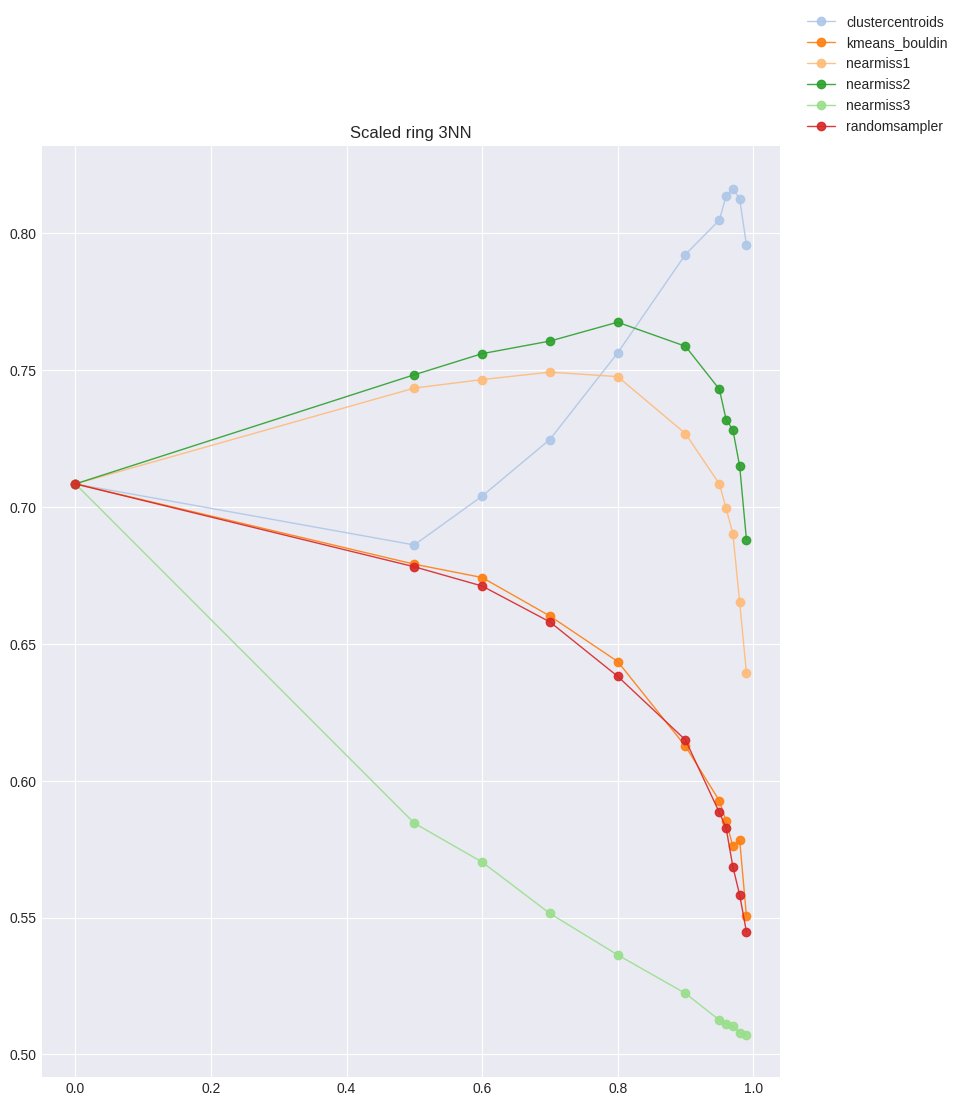

In [13]:
plt.style.use('seaborn-darkgrid')
# plt.title("Acc",fontsize=15)  
# plt.xlabel("Poměr redukce")
# plt.ylabel("Hodnota metriky")
#plt.xscale('log')


# Create a color palette
palette = plt.get_cmap('tab20')
input_files=["ring"]#["banana", "bupa", "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
models=new_format["Model"].unique()
print(models)
for file in input_files:
    fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(8, 10))
    for model,index in zip(models,pd.MultiIndex.from_product([[0,1,2],[0,1]]).to_list()):
        
        plot_data=new_format[new_format["Dataset"]==file]
        plot_data=plot_data[plot_data["Model"]==model].drop(columns=["Model"])
        print(plot_data)
        plot_data=plot_data.pivot(columns='Method',index='RED',values="ACC").reset_index()
       # print(plot_data)
        #plot_data.fillna(plot_data['old'][0],inplace=True)
        names=plot_data.drop("RED", axis=1).columns
        plot_data.loc[0,names] = plot_data['old'][0]
        plot_data.pop("old")
        #plot_data=plot_data.sort_values(by=["RED"])
        print(plot_data)
        num=0
        
        for column in plot_data.drop('RED', axis=1):
            num+=1
            #axes[index[0]][index[1]]
            axes[index[0]][index[1]].plot(plot_data['RED'], plot_data[column], marker='o',color=palette(num), linewidth=1, alpha=0.9, label=column)
        axes[index[0]][index[1]].title.set_text("Scaled "+file+" "+model)
        #axes[index[0]][index[1]].autoscale(enable=True, axis='x', tight=True)
        
        
        #     #plt.plot(new_format['ratio'], new_format[column], marker='o',color=palette(num), linewidth=1, alpha=0.9, label=column)
    #plt.title("Acc "+file,fontsize=15)  
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.02, 1),loc='lower left',ncol=1)
    plt.savefig(f'./results_supervised_high_reduction/{file}_scaled.png',bbox_inches='tight',dpi=300)
    plt.show()
    
   



# show legend


#plt.savefig(f"{use_case}/{use_case}_inc_balcomp_{current_metric}.pdf",bbox_inches='tight')
# show graph
